# Import Required Packages/Dependencies

In [1]:
import tensorflow as tf
import tensorflow.compat.v1 as tf
import numpy as np
import torch
import pandas as pd
from keras.utils.np_utils import to_categorical
from tensorflow.keras import Sequential
from tensorflow.keras.layers import Conv2D, Flatten, Dense
from keras.optimizers import SGD
from tensorflow.keras.callbacks import EarlyStopping
from keras.utils import plot_model

Using TensorFlow backend.


# Read in CDCCondition dataset

In [2]:
cond = pd.read_csv("CDCconditions.csv")

In [3]:
cond.head(10)

,Data as of,Start Week,End Week,State,Condition Group,Condition,ICD10_codes,Age Group,Number of COVID-19 Deaths,Flag
0,11/8/2020,2/1/2020,11/7/2020,US,Respiratory diseases,Influenza and pneumonia,J09-J18,0-24,160.0,NaN
1,11/8/2020,2/1/2020,11/7/2020,US,Respiratory diseases,Influenza and pneumonia,J09-J18,25-34,772.0,NaN
2,11/8/2020,2/1/2020,11/7/2020,US,Respiratory diseases,Influenza and pneumonia,J09-J18,35-44,1981.0,NaN
3,11/8/2020,2/1/2020,11/7/2020,US,Respiratory diseases,Influenza and pneumonia,J09-J18,45-54,5606.0,NaN
4,11/8/2020,2/1/2020,11/7/2020,US,Respiratory diseases,Influenza and pneumonia,J09-J18,55-64,13490.0,NaN
5,11/8/2020,2/1/2020,11/7/2020,US,Respiratory diseases,Influenza and pneumonia,J09-J18,65-74,22222.0,NaN
6,11/8/2020,2/1/2020,11/7/2020,US,Respiratory diseases,Influenza and pneumonia,J09-J18,75-84,25721.0,NaN
7,11/8/2020,2/1/2020,11/7/2020,US,Respiratory diseases,Influenza and pneumonia,J09-J18,85+,25824.0,NaN
8,11/8/2020,2/1/2020,11/7/2020,US,Respiratory diseases,Influenza and pneumonia,J09-J18,Not stated,2.0,NaN
9,11/8/2020,2/1/2020,11/7/2020,US,Respiratory diseases,Influenza and pneumonia,J09-J18,All Ages,95778.0,NaN


# Data Wrangling
* Only select observations where Age Group = 'All Ages', and drop the 'Flag' column.
* Also, reset the index

In [4]:
cond3 = cond.loc[(cond['Age Group'] == "All Ages")].iloc[:, 3:].reset_index().drop(['index','Flag'], axis=1)

cond3

,State,Condition Group,Condition,ICD10_codes,Age Group,Number of COVID-19 Deaths
0,US,Respiratory diseases,Influenza and pneumonia,J09-J18,All Ages,95778.0
1,US,Respiratory diseases,Chronic lower respiratory diseases,J40-J47,All Ages,19486.0
2,US,Respiratory diseases,Adult respiratory distress syndrome,J80,All Ages,28090.0
3,US,Respiratory diseases,Respiratory failure,J96,All Ages,77611.0
4,US,Respiratory diseases,Respiratory arrest,R09.2,All Ages,4492.0
...,...,...,...,...,...,...
1229,PR,Vascular and unspecified dementia,Vascular and unspecified dementia,"F01, F03",All Ages,21.0
1230,PR,Renal failure,Renal failure,N17-N19,All Ages,107.0
1231,PR,"Intentional and unintentional injury, poisonin...","Intentional and unintentional injury, poisonin...","S00-T98, V01-X59, X60-X84, X85-Y09, Y10-Y36, Y...",All Ages,40.0
1232,PR,All other conditions and causes (residual),All other conditions and causes (residual),"A00-A39, A42-B99, D00-E07, E15-E64, E70-E90, F...",All Ages,451.0


* Having used 'All Age' to filter out unwanted observations, you can now drop the State, ICD10_codes, Age Group columns entirely. You should only be left with Condition Group, Condition, and Number of COVID-10 Deaths columns.

In [5]:
cond4 = cond3.filter(['Condition Group', 'Condition', 'Number of COVID-19 Deaths'])
cond4

,Condition Group,Condition,Number of COVID-19 Deaths
0,Respiratory diseases,Influenza and pneumonia,95778.0
1,Respiratory diseases,Chronic lower respiratory diseases,19486.0
2,Respiratory diseases,Adult respiratory distress syndrome,28090.0
3,Respiratory diseases,Respiratory failure,77611.0
4,Respiratory diseases,Respiratory arrest,4492.0
...,...,...,...
1229,Vascular and unspecified dementia,Vascular and unspecified dementia,21.0
1230,Renal failure,Renal failure,107.0
1231,"Intentional and unintentional injury, poisonin...","Intentional and unintentional injury, poisonin...",40.0
1232,All other conditions and causes (residual),All other conditions and causes (residual),451.0


# Define a User Function to create 3 'bins' or groups for the Number of COVID-19 Deaths variable.
* The recode will work as follows:
* Anything less than 1000 = "Less than or equal to 1000"
* Anything between 1000 and 10000 = "Above 1000 and less or equal to 10,000"
* Anything greater than or equal to 10,000 = "Above 10,000"

In [6]:
def dependent_recode (series): 
    if series <= 1000:
        return "Less than or equal to 1000"
    if series > 1000 and series < 10000: 
        return "Above 1000 and less or equal to 10,000"
    if series >= 10000: 
        return "Above 10,000"

* Now use the .apply() function to recode the 'Number of COVID-19 Deaths' variable:

In [7]:
cond4['Number of COVID-19 Deaths'] = cond4['Number of COVID-19 Deaths'].apply(dependent_recode)

* Display dataset to confirm successful recode:

In [8]:
cond4.head()

,Condition Group,Condition,Number of COVID-19 Deaths
0,Respiratory diseases,Influenza and pneumonia,"Above 10,000"
1,Respiratory diseases,Chronic lower respiratory diseases,"Above 10,000"
2,Respiratory diseases,Adult respiratory distress syndrome,"Above 10,000"
3,Respiratory diseases,Respiratory failure,"Above 10,000"
4,Respiratory diseases,Respiratory arrest,"Above 1000 and less or equal to 10,000"


* Next, convert the remaining columns into discreet numerical values using the pandas Categorical function. 
* then generate unique codes for each Condition Group, each Condition, and Number of COVID-19 Deaths.

In [9]:
cond4['Condition Group'] = pd.Categorical(cond4['Condition Group'])
cond4['Condition Group'] = cond4['Condition Group'].cat.codes

cond4['Condition'] = pd.Categorical(cond4['Condition'])
cond4['Condition'] = cond4['Condition'].cat.codes


cond4['Number of COVID-19 Deaths'] = pd.Categorical(cond4['Number of COVID-19 Deaths'])
cond4['Number of COVID-19 Deaths'] = cond4['Number of COVID-19 Deaths'].cat.codes

cond5 = cond4.drop(['Number of COVID-19 Deaths'], axis=1).values

print(cond5.shape)
print(cond5)

(1234, 2)
[[ 9 11]
 [ 9  7]
 [ 9  0]
 ...
 [ 5 12]
 [ 0  1]
 [ 2  3]]


* Create variable n_cols and store the shape of the column at position index 1 of the dataset.
* Create target vairable and convert it from one column to multiple columns using the "to_categorical()" function.
* Create input_nodes and output_nodes to hold the number of nodes for the input and output layers respectively.

In [10]:
n_cols = cond5.shape[1]
input_nodes = cond5.shape[0]
target = to_categorical(cond4['Number of COVID-19 Deaths'])
output_nodes = len(target[1])
print(n_cols)
print(input_nodes)
print(target)
print(output_nodes)

2
1234
[[1. 0. 0.]
 [1. 0. 0.]
 [1. 0. 0.]
 ...
 [0. 0. 1.]
 [0. 0. 1.]
 [0. 0. 1.]]
3


# Next, create model structure, compile, fit, and predict. Use 'relu' as the activation function for the hidden layers, and 'softmax' as the activation function for the output layer.
# Also, use 'adam' as optimizer, 'categorical_crossentropy' as the loss function, and metrics=['accuracy'].
# Ensure EarlyStopping doesn't exceed 2 epochs if there's no improvement on accuracy.

In [11]:
model = Sequential()

model.add(Dense(input_nodes, activation='relu'))

model.add(Dense(input_nodes, activation='relu', input_shape = (n_cols,)))

model.add(Dense(input_nodes, activation='relu'))

model.add(Dense(input_nodes, activation='relu'))

model.add(Dense(output_nodes, activation='softmax'))

model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])

early_stopping_monitor = EarlyStopping(patience=2)

history = model.fit(cond5, target, batch_size=30, verbose=1, validation_split=0.3, epochs=10, callbacks=[early_stopping_monitor])

print(history)


Epoch 1/10
29/29 [==============================] - 1s 25ms/step - loss: 0.7159 - accuracy: 0.8111 - val_loss: 0.4634 - val_accuracy: 0.8544
Epoch 2/10
29/29 [==============================] - 1s 21ms/step - loss: 0.5832 - accuracy: 0.8204 - val_loss: 0.4567 - val_accuracy: 0.8544
Epoch 3/10
29/29 [==============================] - 1s 28ms/step - loss: 0.5812 - accuracy: 0.8204 - val_loss: 0.4930 - val_accuracy: 0.8544
Epoch 4/10
29/29 [==============================] - 1s 22ms/step - loss: 0.5602 - accuracy: 0.8204 - val_loss: 0.4469 - val_accuracy: 0.8544
Epoch 5/10
29/29 [==============================] - 1s 22ms/step - loss: 0.5535 - accuracy: 0.8204 - val_loss: 0.4450 - val_accuracy: 0.8544
Epoch 6/10
29/29 [==============================] - 1s 22ms/step - loss: 0.5472 - accuracy: 0.8192 - val_loss: 0.4730 - val_accuracy: 0.8544
Epoch 7/10
29/29 [==============================] - 1s 23ms/step - loss: 0.5805 - accuracy: 0.8273 - val_loss: 0.4291 - val_accuracy: 0.8544
Epoch 8/10
29

# Evaluate Model

In [12]:
print(model.evaluate(cond5, target, verbose=True))

39/39 [==============================] - 0s 5ms/step - loss: 0.4987 - accuracy: 0.8371
[0.4986804127693176, 0.8371150493621826]


# Predict and Print results

In [13]:
predictions = model.predict(cond5)

In [14]:
print(predictions)

[[0.02675855 0.14373966 0.8295018 ]
 [0.02043336 0.10765695 0.8719097 ]
 [0.00976269 0.06343191 0.9268054 ]
 ...
 [0.0134195  0.07586592 0.91071457]
 [0.03173228 0.53566617 0.4326016 ]
 [0.03311935 0.13562658 0.83125407]]


# Summarize Model Structure:

In [15]:
model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense (Dense)                (None, 1234)              3702      
_________________________________________________________________
dense_1 (Dense)              (None, 1234)              1523990   
_________________________________________________________________
dense_2 (Dense)              (None, 1234)              1523990   
_________________________________________________________________
dense_3 (Dense)              (None, 1234)              1523990   
_________________________________________________________________
dense_4 (Dense)              (None, 3)                 3705      
Total params: 4,579,377
Trainable params: 4,579,377
Non-trainable params: 0
_________________________________________________________________


# Visualize the model history

# Import required package

In [16]:
import matplotlib.pyplot as plt

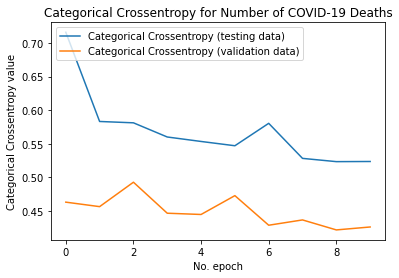

In [17]:
# Plot history: Categorical Crossentropy
plt.plot(history.history['loss'], label='Categorical Crossentropy (testing data)')
plt.plot(history.history['val_loss'], label='Categorical Crossentropy (validation data)')
plt.title('Categorical Crossentropy for Number of COVID-19 Deaths')
plt.ylabel('Categorical Crossentropy value')
plt.xlabel('No. epoch')
plt.legend(loc="upper left")
plt.show()